In [967]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import json
from datetime import datetime
import chardet
import re
import networkx as nx
import community as community_louvain
import random

In [968]:
def safe_get(dictionary, *keys):
    """Safely get a value from nested dictionaries."""
    for key in keys:
        if isinstance(dictionary, dict) and key in dictionary:
            dictionary = dictionary[key]
        else:
            return None
    return dictionary

uniqueUsers = set()
hashtagsCount = dict()
mencionesCount = dict()
mencionesMadePorUsuario = dict()
mencionesMadePorHashtag = dict()


tweets = []
with open('traficogt.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('{'):
            try:
                tweet = json.loads(line.strip())

                userName = safe_get(tweet, 'user', 'username')
                if userName is not None:
                    uniqueUsers.add(userName)

                inReplyUser = safe_get(tweet, 'inReplyToUser', 'username')
                uniqueUsers.add(inReplyUser)

                usernames = [safe_get(mention, 'username') for mention in safe_get(tweet, 'mentionedUsers')]
                usernames = [username.lower() for username in usernames if username is not None]
                usernames = [re.sub(r"[^a-z0-9 ]", '', username) for username in usernames if username is not None]


                hashtags = safe_get(tweet, 'hashtags')
                hashtags = [hashtag.lower() for hashtag in hashtags if hashtag is not None]
                hashtags = [re.sub(r"[^a-z0-9 ]", '', hashtag) for hashtag in hashtags if hashtag is not None]
                for hashtag in hashtags:
                    if hashtag in hashtagsCount:
                        hashtagsCount[hashtag] += 1
                    else:
                        hashtagsCount[hashtag] = 1


                username_len = len(usernames)

                if user in mencionesMadePorUsuario:
                    mencionesMadePorUsuario[user] += username_len
                    if hashtags:
                        for hashtag in hashtags:
                            mencionesMadePorHashtag[hashtag] = username_len
                else:
                    mencionesMadePorUsuario[user] = username_len
                    if hashtags:
                        for hashtag in hashtags:
                            mencionesMadePorHashtag[hashtag] = username_len

                for user in usernames:
                    uniqueUsers.add(user)
                    if user in mencionesCount:
                        mencionesCount[user] += 1
                    else:
                        mencionesCount[user] = 1

                tweets.append({
                    'date': safe_get(tweet, 'date'),
                    'content': safe_get(tweet, 'rawContent'),
                    'username': userName,
                    'replyCount': safe_get(tweet, 'replyCount'),
                    'retweetCount': safe_get(tweet, 'retweetCount'),
                    'quoteCount': safe_get(tweet, 'quoteCount'),
                    'bookmarkedCount': safe_get(tweet, 'bookmarkedCount'),
                    'likeCount': safe_get(tweet, 'likeCount'),
                    'viewCount': safe_get(tweet, 'viewCount'),
                    'inReplyToUser': inReplyUser,
                    'mentionedUsers': usernames,
                    'hashtags': safe_get(tweet, 'hashtags'),
                })
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON: {line[:50]}...")
                print(json.JSONDecodeError)
        else:
            print(f"Skipping non-JSON line: {line[:50]}...")

df = pd.DataFrame(tweets)

df

,date,content,username,replyCount,retweetCount,quoteCount,bookmarkedCount,likeCount,viewCount,inReplyToUser,mentionedUsers,hashtags
0,2024-09-12 14:22:06+00:00,Es comprensible la resolución... El ruso sabe ...,traficogt,0,0,0,0,1,393.0,None,[],[]
1,2024-09-12 00:39:56+00:00,La corrupción de la @CC_Guatemala\nes descarad...,monymmorales,0,56,4,1,84,1587.0,None,[ccguatemala],[]
2,2024-09-12 01:21:04+00:00,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,animaldgalaccia,0,0,0,0,1,91.0,PNCdeGuatemala,"[pncdeguatemala, mingobguate, fjimenezmingob, ...",[]
3,2024-09-11 20:20:01+00:00,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,EstacionDobleA,0,0,0,0,0,46.0,EstacionDobleA,"[amilcarmontejo, aztecanoticiagt, bancadasemil...",[]
4,2024-09-11 00:34:31+00:00,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,CubReserva,0,0,0,0,1,171.0,CubReserva,"[soy502, aztecanoticiagt, conapgt, denunciaemp...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...
5600,2023-10-08 21:37:45+00:00,@hshetemul @traficogt Y de igual Manera quitan...,mvtrooper,0,0,0,0,0,3.0,hshetemul,"[hshetemul, traficogt, mpguatemala, cangguatem...",[]
5601,2023-10-08 21:37:19+00:00,@traficogt Es algo más fuerte que ellos no qui...,elmeronene1,0,0,0,0,0,21.0,traficogt,[traficogt],[]
5602,2023-10-08 21:31:24+00:00,@Factor4_GT @traficogt @CC_Guatemala @MPguatem...,mvtrooper,0,0,0,0,0,4.0,Factor4_GT,"[factor4gt, traficogt, ccguatemala, mpguatemala]",[]
5603,2023-10-08 21:13:33+00:00,@AgenciaOcote @traficogt Vieja ignorante,91072dff5a5a4f1,0,0,0,0,0,17.0,AgenciaOcote,"[agenciaocote, traficogt]",[]


## Preprocesamiento de datos

### Cambios en content

In [969]:
df['content'] = df['content'].str.lower()
df['content'] = df['content'].str.replace(r'http\S+|www.\S+', '', regex=True)
df['content'] = df['content'].str.replace(r'@\S+|#\S+', '', regex=True)
df['content'] = df['content'].str.replace(r"[^a-z0-9 ]", '', regex=True)

In [970]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/estebandonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [971]:
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    words = text.split()
    processed_words = [word for word in words if word not in stop_words]
    return ' '.join(processed_words)

In [972]:
df['content'] = df['content'].apply(preprocess_text)

### Cambios en username

In [973]:
df['username'] = df['username'].str.lower()
df['content'] = df['content'].str.replace(r"[^a-z0-9 ]", '', regex=True)

### Cambios en inReplyToUser

In [974]:
df['inReplyToUser'] = df['inReplyToUser'].str.lower()
df['content'] = df['content'].str.replace(r"[^a-z0-9 ]", '', regex=True)

## Análisis Exploratorio

In [975]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5605 entries, 0 to 5604
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             5605 non-null   object 
 1   content          5605 non-null   object 
 2   username         5605 non-null   object 
 3   replyCount       5605 non-null   int64  
 4   retweetCount     5605 non-null   int64  
 5   quoteCount       5605 non-null   int64  
 6   bookmarkedCount  5605 non-null   int64  
 7   likeCount        5605 non-null   int64  
 8   viewCount        5601 non-null   float64
 9   inReplyToUser    4151 non-null   object 
 10  mentionedUsers   5605 non-null   object 
 11  hashtags         5605 non-null   object 
dtypes: float64(1), int64(5), object(6)
memory usage: 525.6+ KB


In [976]:
print("Cantidad de tweets: ", len(df))

Cantidad de tweets:  5605


In [977]:
print("Usuarios únicos: ",len(uniqueUsers))

Usuarios únicos:  3191


In [978]:
sortedHashtags = sorted(hashtagsCount.items(), key=lambda x: x[1], reverse=True)
print("Hashtags frecuentes: ")
for hashtag, count in sortedHashtags[:10]:
    print(f"{hashtag}: {count}")

Hashtags frecuentes: 
ahora: 30
guatemala: 25
ahoralh: 19
urgente: 16
traficogt: 16
renunciengolpistas: 15
paronacionalindefinido: 9
lahoradeactualizarnos: 8
guateresiste: 8
paronacionaindefinido: 8


In [979]:
sortedMenciones = sorted(mencionesCount.items(), key=lambda x: x[1], reverse=True)
print("Usuarios más mencionados: ")
for user, count in sortedMenciones[:10]:
    print(f"{user}: {count}")

Usuarios más mencionados: 
traficogt: 4244
barevalodeleon: 432
drgiammattei: 176
amilcarmontejo: 166
prensacomunitar: 162
mpguatemala: 138
mmendozagt: 133
lahoragt: 128
ccguatemala: 110
muniguate: 99


In [980]:
G = nx.Graph()

In [981]:
for user in uniqueUsers:
    if user is not None:
        G.add_node(user)

In [982]:
for index, row in df.iterrows():
    inReplyUsername = row['inReplyToUser']
    if inReplyUsername:
        G.add_edge(row['username'], inReplyUsername)
    
    if row['mentionedUsers']:
        for mentionedUser in row['mentionedUsers']:
            if not G.has_edge(row['username'], mentionedUser):
                G.add_edge(row['username'], mentionedUser)

### Preguntas

#### ¿Cuántos nodos sin conexiones tenemos?

In [983]:
isolated_nodes = list(nx.isolates(G))
print(f"Cantidad de nodos sin conexiones: ", len(isolated_nodes))

Cantidad de nodos sin conexiones:  1308


#### ¿Cuál fue el hashtag que generó más conexiones?

In [984]:
print(f"Usuario con mayor cantidad de menciones hechas: {max(mencionesMadePorHashtag)}")

Usuario con mayor cantidad de menciones hechas: zona5


#### ¿Quién fue el usuario con más menciones hechas?

In [985]:
print(f"Usuario con mayor cantidad de menciones hechas: {max(mencionesMadePorUsuario)}")

Usuario con mayor cantidad de menciones hechas: zuryxguate


## Creación de gráfico

In [986]:
G.remove_nodes_from(isolated_nodes)

In [987]:
degree_dict = dict(G.degree(G.nodes()))

degrees = dict(G.degree())
print(degrees)

max_degree = 40
print("Max degree:", max_degree)
min_degree = min(degrees.values())
print("Min degree:", min_degree)

{'pmtsanlucassac': 2, 'paulabitencourt': 1, 'polaris2111': 3, 'mario1968lopez': 1, 'conapgt': 12, '_guisii': 12, 'aguayjoma': 3, 'hoponovale': 2, 'c8f9a667e131454': 5, 'empaguagt': 11, 'clauflor7': 14, 'orlandomagic81': 1, 'fdbedout': 1, 'analuisamirand8': 3, 'vozdeltuit': 23, 'insightcrimees': 1, 'fenanu': 6, 'mundocrema': 3, 'fiaheisenberg': 7, 'luisca_o': 2, 'jalel78': 4, 'migm10r': 7, 'ramiromz': 3, 'drsagas': 1, 'rdiazcorzo': 4, 'drewzecena': 6, 'patriciajaniot': 5, 'howardroark1962': 2, 'llamarseraffa': 1, 'julioca75923080': 21, 'congressdotgov': 1, 'anabelynz': 1, 'kennethmz': 14, 'chapina_en': 3, 'kevini': 1, 'pholitaw': 7, 'renunciayagt': 2, 'monymmorales': 22, 'freevirginial': 1, 'leraovalle': 2, 'denunciasmuni': 1, 'cesargarcia0293': 2, 'asdlkjhdf': 3, 'villanueva_ci': 4, 'sylguru': 1, 'tetobustamante': 5, 'hatecorruptos': 1, 'dcuevas_gtv': 1, 'adrianpc912': 1, 'josuefiallo': 1, 'kestleredwin': 2, 'sremx': 1, 'masmeisamas': 1, 'luisalemus49': 1, 'transmision14': 2, 'jjpnewsg

In [988]:
cmap = plt.cm.viridis

node_colors = []
for node in G.nodes():
    degree = degrees[node]

    norm_degree = (degree - min_degree) / (max_degree - min_degree) if max_degree > min_degree else 0
    node_colors.append(cmap(norm_degree))

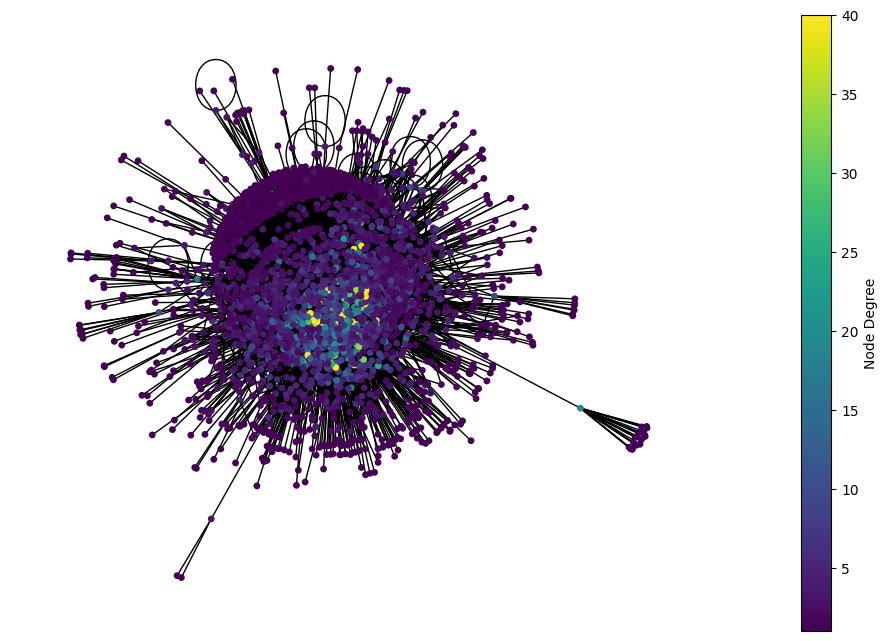

In [989]:
plt.figure(figsize=(12, 8))
ax = plt.gca()

pos = nx.spring_layout(G)

nx.draw(G, pos, node_color=node_colors, node_size=15, ax=ax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_degree, vmax=max_degree))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Node Degree', orientation='vertical', pad=0.1)

plt.show()

### Densidad de la red

In [990]:
densidad = nx.density(G)
print("Densidad: ", densidad)

Densidad:  0.0019301240636359622


### Diámetro de la red

In [991]:
def check_connectivity(G):
    if G.is_directed():
        print("El grafo es dirigido.")
        print(f"¿Está fuertemente conectado? {nx.is_strongly_connected(G)}")
        print(f"¿Está débilmente conectado? {nx.is_weakly_connected(G)}")
    else:
        print("El grafo es no dirigido.")
        print(f"¿Está conectado? {nx.is_connected(G)}")

    if G.is_directed():
        num_strong = nx.number_strongly_connected_components(G)
        num_weak = nx.number_weakly_connected_components(G)
        print(f"Número de componentes fuertemente conectados: {num_strong}")
        print(f"Número de componentes débilmente conectados: {num_weak}")
    else:
        num_components = nx.number_connected_components(G)
        print(f"Número de componentes conectados: {num_components}")

    if G.is_directed():
        largest_strong = max(nx.strongly_connected_components(G), key=len)
        largest_weak = max(nx.weakly_connected_components(G), key=len)
        print(f"Tamaño de la componente fuertemente conectada más grande: {len(largest_strong)}")
        print(f"Tamaño de la componente débilmente conectada más grande: {len(largest_weak)}")
    else:
        largest = max(nx.connected_components(G), key=len)
        print(f"Tamaño de la componente conectada más grande: {len(largest)}")

In [992]:
check_connectivity(G)

El grafo es no dirigido.
¿Está conectado? True
Número de componentes conectados: 1
Tamaño de la componente conectada más grande: 2856


In [993]:
diametro = nx.diameter(G)
print("Diámetro de la red: ", diametro)

Diámetro de la red:  7


### Coeficiente de agrupamiento

In [994]:
coef_agrupamiento = nx.average_clustering(G)
print("Coeficiente de agrupamiento: ", coef_agrupamiento)

Coeficiente de agrupamiento:  0.20917984183902757


### Encontrar comunidades utilizando algoritmo de Louvain

In [995]:
def detect_communities(G):
    
    partition = community_louvain.best_partition(G)
    
    return partition

In [996]:
def visualize_graph_with_communities(G, partition):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    
    num_communities = max(partition.values()) + 1
    colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))
    random.shuffle(colors)
    
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size=300, 
                               node_color=[colors[com]], label=f"Community {com}")
    
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    
    plt.title("Communities Detected with Louvain Algorithm")
    plt.legend(scatterpoints=1, loc='lower left', ncol=3, fontsize=8, bbox_to_anchor=(0,1.02,1,0.2))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [997]:
def find_biggest_community(partition):

    community_sizes = {}
    for node, community_id in partition.items():
        if community_id not in community_sizes:
            community_sizes[community_id] = 0
        community_sizes[community_id] += 1
    
    biggest_community_id = max(community_sizes, key=community_sizes.get)
    biggest_community_size = community_sizes[biggest_community_id]
    
    return biggest_community_id, biggest_community_size, community_sizes

In [998]:
partition = detect_communities(G)

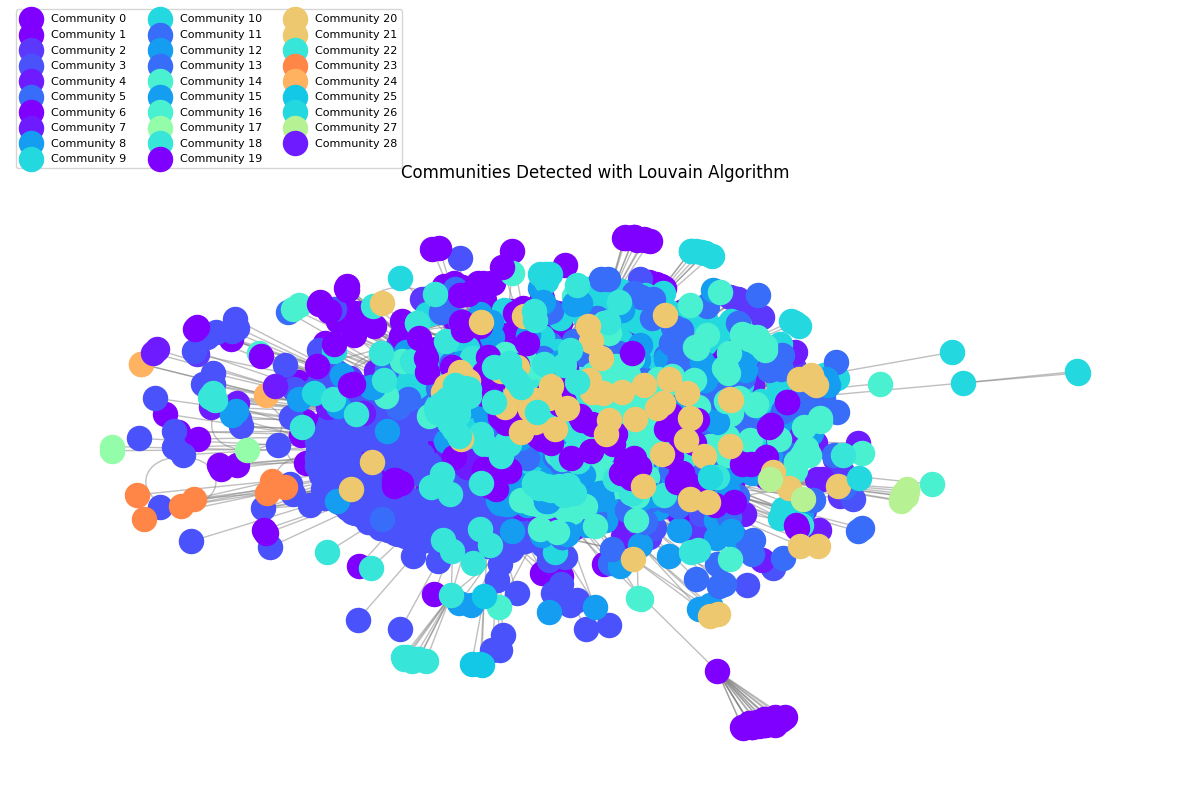

In [999]:
visualize_graph_with_communities(G, partition)

In [1000]:
biggest_community_id, biggest_community_size, community_sizes = find_biggest_community(partition)

print(f"The biggest community is community {biggest_community_id} with {biggest_community_size} nodes.")
print("\nAll community sizes:")

sortedCommunities = dict(sorted(community_sizes.items(), key=lambda item: item[1], reverse=True))

for i, (community_id, size) in enumerate(sortedCommunities.items()):
    if i >= 10:
        break
    print(f"Community {community_id} -> size: {size}")

The biggest community is community 3 with 784 nodes.

All community sizes:
Community 3 -> size: 784
Community 0 -> size: 232
Community 13 -> size: 191
Community 10 -> size: 181
Community 2 -> size: 139
Community 8 -> size: 124
Community 4 -> size: 123
Community 19 -> size: 113
Community 16 -> size: 98
Community 11 -> size: 93


In [1001]:
from collections import Counter

def find_top_3_communities(partition):
    community_sizes = Counter(partition.values())
    return [comm for comm, _ in community_sizes.most_common(3)]

def create_top_3_communities_graph(G, partition):
    top_3_communities = find_top_3_communities(partition)
    
    new_G = nx.Graph()
    
    for node, comm in partition.items():
        if comm in top_3_communities:
            new_G.add_node(node, community=comm)
    
    for edge in G.edges():
        if new_G.has_node(edge[0]) and new_G.has_node(edge[1]):
            new_G.add_edge(*edge)
    
    return new_G, top_3_communities

def visualize_top_3_communities_graph(new_G, top_3_communities):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(new_G)
    
    colors = ['#FF9999', '#66B2FF', '#99FF99']
    
    for i, comm in enumerate(top_3_communities):
        list_nodes = [node for node, data in new_G.nodes(data=True) if data['community'] == comm]
        nx.draw_networkx_nodes(new_G, pos, list_nodes, node_size=300, 
                               node_color=colors[i], label=f"Community {comm}")
    
    nx.draw_networkx_edges(new_G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(new_G, pos, font_size=2, font_weight='bold')
    
    plt.legend(scatterpoints=1, loc='lower left', ncol=3, fontsize=10, bbox_to_anchor=(0,1.02,1,0.2))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

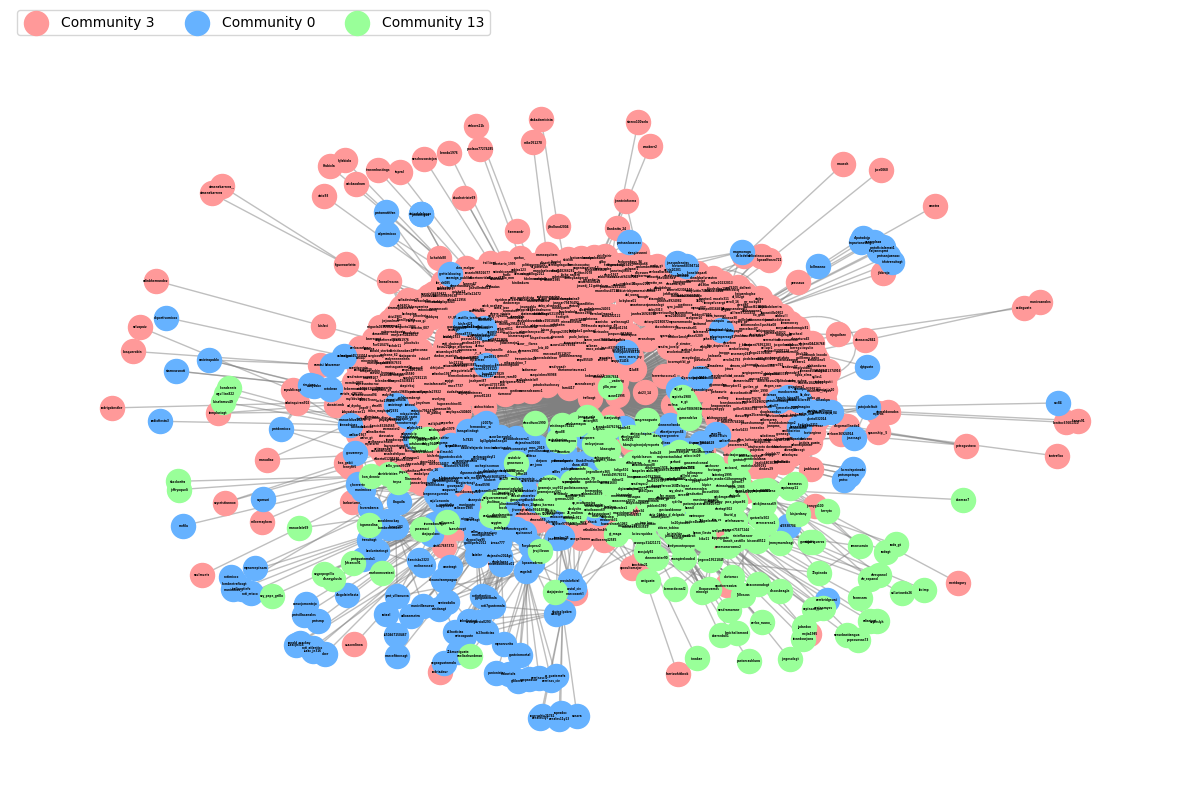

In [1002]:
new_G, top_3_communities = create_top_3_communities_graph(G, partition)
visualize_top_3_communities_graph(new_G, top_3_communities)